In [1]:
from PIL import Image 
%matplotlib inline 
import matplotlib
import matplotlib.pyplot as plt 
import torch 
from torch.utils.data import Dataset,DataLoader
import numpy as np 
import torchvision
from torchvision import transforms
import torchvision.datasets as dsets
import torch.nn.init
from torchsummary import summary
import torch.nn as nn
import os
import time
import torch.nn.functional as F

In [2]:
trans = transforms.Compose([transforms.Grayscale(num_output_channels=1),
                            transforms.ToTensor(),
                            transforms.Normalize((0.5,),(0.5,))
                            ])
trainset = torchvision.datasets.ImageFolder(root="C:/Users/1315/Desktop/expression/face/far2013/train",
                                            transform = trans)


testset = torchvision.datasets.ImageFolder(root="C:/Users/1315/Desktop/expression/face/far2013/test",
                                            transform = trans)

In [3]:
trainloader = DataLoader(trainset,
                        batch_size=1,
                        shuffle=True,
                        num_workers=4)
                    
testloader = DataLoader(testset,
                        batch_size=1,
                        shuffle=False,
                        num_workers=4)

classes = testset.classes

In [4]:
train_dataiter = iter(trainloader)
test_dataiter = iter(testloader)

train_images,train_labels = train_dataiter.next()
test_images,test_labels = test_dataiter.next()

torch.Size([1, 1, 48, 48])


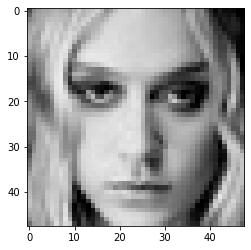

In [5]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
print(train_images.shape)
imshow(torchvision.utils.make_grid(train_images,nrow=4))
#print(train_images.shape)
#print((torchvision.utils.make_grid(train_images)).shape)
#print(" ".join("%s"%classes[train_labels[j]] for j in range(1)))

In [6]:
class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        # BatchNorm에 bias가 포함되어 있으므로, conv2d는 bias=False로 설정합니다.
        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels * BasicBlock.expansion, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels * BasicBlock.expansion),
        )

        # identity mapping, input과 output의 feature map size, filter 수가 동일한 경우 사용.
        self.shortcut = nn.Sequential()

        self.relu = nn.ReLU()

        # projection mapping using 1x1conv
        if stride != 1 or in_channels != BasicBlock.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * BasicBlock.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * BasicBlock.expansion)
            )

    def forward(self, x):
        x = self.residual_function(x) + self.shortcut(x)
        x = self.relu(x)
        return x


class BottleNeck(nn.Module):
    expansion = 4
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels * BottleNeck.expansion, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels * BottleNeck.expansion),
        )

        self.shortcut = nn.Sequential()

        self.relu = nn.ReLU()

        if stride != 1 or in_channels != out_channels * BottleNeck.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels*BottleNeck.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels*BottleNeck.expansion)
            )
            
    def forward(self, x):
        x = self.residual_function(x) + self.shortcut(x)
        x = self.relu(x)
        return x

In [7]:
class ResNet(nn.Module):
    def __init__(self, block, num_block, num_classes=10, init_weights=True):
        super().__init__()

        self.in_channels=64

        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        self.conv2_x = self._make_layer(block, 64, num_block[0], 1)
        self.conv3_x = self._make_layer(block, 128, num_block[1], 2)
        self.conv4_x = self._make_layer(block, 256, num_block[2], 2)
        self.conv5_x = self._make_layer(block, 512, num_block[3], 2)

        self.avg_pool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        # weights inittialization
        if init_weights:
            self._initialize_weights()

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion

        return nn.Sequential(*layers)

    def forward(self,x):
        output = self.conv1(x)
        output = self.conv2_x(output)
        x = self.conv3_x(output)
        x = self.conv4_x(x)
        x = self.conv5_x(x)
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

    # define weight initialization function
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

def resnet18():
    return ResNet(BasicBlock, [2,2,2,2])

def resnet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])

def resnet50():
    return ResNet(BottleNeck, [3,4,6,3])

def resnet101():
    return ResNet(BottleNeck, [3, 4, 23, 3])

def resnet152():
    return ResNet(BottleNeck, [3, 8, 36, 3])

In [8]:

class Deep_Emotion(nn.Module):
    def __init__(self):
        '''
        Deep_Emotion class contains the network architecture.
        '''
        super(Deep_Emotion,self).__init__()
        self.conv1 = nn.Conv2d(1,10,3)
        self.conv2 = nn.Conv2d(10,10,3)
        self.pool2 = nn.MaxPool2d(2,2)

        self.conv3 = nn.Conv2d(10,10,3)
        self.conv4 = nn.Conv2d(10,10,3)
        self.pool4 = nn.MaxPool2d(2,2)

        self.Resnet34 = resnet34()
        self.norm = nn.BatchNorm2d(10)

        self.fc1 = nn.Linear(10,50)
        self.fc2 = nn.Linear(50,7)

        self.gap = nn.AdaptiveAvgPool2d(1)

        self.localization = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
        )

        self.fc_loc = nn.Sequential(
            nn.Linear(640,32),
            nn.ReLU(True),
            nn.Linear(32, 2*3)
        )
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))

    def stn(self, x):
        xs = self.localization(x)
        xs = xs.view(-1, 640)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)
        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid,align_corners=True)
   
        return x

    def forward(self,input):
        out = self.stn(input)
        out = self.Resnet34(out)
        out = F.dropout(out)
        out = F.relu(self.fc1(out))
        out = self.fc2(out)
        
        return out

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Deep_Emotion().to(device)
x = torch.randn(3, 1, 48, 48).to(device)
output = model(x)
print(output.size())

torch.Size([3, 7])


C:\Users\1315\anaconda3\lib\site-packages\torch\nn\functional.py:3448: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


In [10]:
summary(model, (1, 48, 48), device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 42, 42]             400
         MaxPool2d-2            [-1, 8, 21, 21]               0
              ReLU-3            [-1, 8, 21, 21]               0
            Conv2d-4           [-1, 10, 17, 17]           2,010
         MaxPool2d-5             [-1, 10, 8, 8]               0
              ReLU-6             [-1, 10, 8, 8]               0
            Linear-7                   [-1, 32]          20,512
              ReLU-8                   [-1, 32]               0
            Linear-9                    [-1, 6]             198
           Conv2d-10           [-1, 64, 24, 24]           3,136
      BatchNorm2d-11           [-1, 64, 24, 24]             128
             ReLU-12           [-1, 64, 24, 24]               0
        MaxPool2d-13           [-1, 64, 12, 12]               0
           Conv2d-14           [-1, 64,

In [11]:
loss_func = nn.CrossEntropyLoss(reduction='sum')
opt = torch.optim.Adam(model.parameters(), lr=0.005)

from torch.optim.lr_scheduler import ReduceLROnPlateau
lr_scheduler = ReduceLROnPlateau(opt, mode='min', factor=0.1, patience=10)

In [12]:
# function to get current lr
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

In [13]:
# function to calculate metric per mini-batch
def metric_batch(output, target):
    pred = output.argmax(1, keepdim=True)
    corrects = pred.eq(target.view_as(pred)).sum().item()
    return corrects


# function to calculate loss per mini-batch
def loss_batch(loss_func, output, target, opt=None):
    loss = loss_func(output, target)
    metric_b = metric_batch(output, target)

    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()

    return loss.item(), metric_b

In [14]:
# function to calculate loss and metric per epoch
def loss_epoch(model, loss_func, dataset_dl, sanity_check=False, opt=None):
    running_loss = 0.0
    running_metric = 0.0
    len_data = len(dataset_dl.dataset)

    for xb, yb in dataset_dl:
        xb = xb.to(device)
        yb = yb.to(device)
        output = model(xb)

        loss_b, metric_b = loss_batch(loss_func, output, yb, opt)

        running_loss += loss_b
        
        if metric_b is not None:
            running_metric += metric_b
        
        if sanity_check is True:
            break

    loss = running_loss / len_data
    metric = running_metric / len_data

    return loss, metric

In [15]:
# function to start training
def train_val(model, params):
    num_epochs=params['num_epochs']
    loss_func=params["loss_func"]
    opt=params["optimizer"]
    train_dl=params["train_dl"]
    val_dl=params["val_dl"]
    sanity_check=params["sanity_check"]
    lr_scheduler=params["lr_scheduler"]
    path2weights=params["path2weights"]

    loss_history = {'train': [], 'val': []}
    metric_history = {'train': [], 'val': []}

    # # GPU out of memoty error
    # best_model_wts = copy.deepcopy(model.state_dict())

    best_loss = float('inf')

    start_time = time.time()

    for epoch in range(num_epochs):
        current_lr = get_lr(opt)
        print('Epoch {}/{}, current lr={}'.format(epoch, num_epochs-1, current_lr))

        model.train()
        train_loss, train_metric = loss_epoch(model, loss_func, train_dl, sanity_check, opt)
        loss_history['train'].append(train_loss)
        metric_history['train'].append(train_metric)

        model.eval()
        with torch.no_grad():
            val_loss, val_metric = loss_epoch(model, loss_func, val_dl, sanity_check)
        loss_history['val'].append(val_loss)
        metric_history['val'].append(val_metric)

        if val_loss < best_loss:
            best_loss = val_loss
            # best_model_wts = copy.deepcopy(model.state_dict())

            # torch.save(model.state_dict(), path2weights)
            # print('Copied best model weights!')
            print('Get best val_loss')

        lr_scheduler.step(val_loss)

        print('train loss: %.6f, val loss: %.6f, accuracy: %.2f, time: %.4f min' %(train_loss, val_loss, 100*val_metric, (time.time()-start_time)/60))
        print('-'*10)

    # model.load_state_dict(best_model_wts)

    return model, loss_history, metric_history

In [16]:
# definc the training parameters
params_train = {
    'num_epochs':50,
    'optimizer':opt,
    'loss_func':loss_func,
    'train_dl':trainloader,
    'val_dl':testloader,
    'sanity_check':False,
    'lr_scheduler':lr_scheduler,
    'path2weights':'./models/weights.pt',
}

# create the directory that stores weights.pt
def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSerror:
        print('Error')
createFolder('./models')

In [17]:
model, loss_hist, metric_hist = train_val(model, params_train)

Epoch 0/49, current lr=0.005
Get best val_loss
train loss: 1.817949, val loss: 1.814630, accuracy: 24.71, time: 14.8424 min
----------
Epoch 1/49, current lr=0.005
train loss: 1.812698, val loss: 1.815536, accuracy: 24.71, time: 29.4282 min
----------
Epoch 2/49, current lr=0.005
Get best val_loss
train loss: 1.812733, val loss: 1.814591, accuracy: 24.71, time: 43.9025 min
----------
Epoch 3/49, current lr=0.005
train loss: 1.812359, val loss: 1.815517, accuracy: 24.71, time: 58.7090 min
----------
Epoch 4/49, current lr=0.005
train loss: 1.812763, val loss: 1.814689, accuracy: 24.71, time: 73.3636 min
----------
Epoch 5/49, current lr=0.005


KeyboardInterrupt: 

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(trainloader['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(classes[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)